In [55]:
# Install the required libraries
!pip install prophet

In [56]:
# Dependencies
# NOTE: We might not use all of these. I just improrted everything I can think of for now. We'll delete the ones we don't need later
import requests
import time
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import json
from pathlib import Path

In [57]:
#Read data into the notebook
aicompany_profits_df = pd.read_csv('./data_sets/AI_AmericanCompaniesProfits.csv').dropna()
linkedin_postings_df = pd.read_csv('./data_sets/postings.csv').dropna()
machine_learning_jobs_df = pd.read_json('./data_sets/job_data.json', lines=True)

In [87]:
print(aicompany_profits_df.head(5))

              Company Name              Sector  Profits in USD  \
0                3Com Corp                tech          388550   
1               3M Company       manufacturing          295319   
2        A.G. Edwards Inc.  financial services          956265   
3      Abbott Laboratories          healthcare          945432   
4  Abercrombie & Fitch Co.              retail          958207   

                                        AI Benefits  
0     Improved product functionality and efficiency  
1         Optimized operations and quality control   
2  Fraud detection and personalized recommendations  
3       Enhanced diagnostics and precision medicine  
4     Demand forecasting and inventory optimization  


***Introduction*** 
The goal of this exploratory data analysis is to characterize and investigate the growth of machine learning as a job skill. We are interested in looking at this topic along a number angles. TBC....

QUESTION Geography 

In [58]:
# Insert Question 1 analysis and visualizations here. Insert new cells if necessary 

Q1 Summary \[INSERT SUMMARY HERE] ... write a little about what the findings above seem to indicate about question 1

Question 2 Relative proportions ML to not-ML

In [59]:
# Insert question 2 analysis etc here. Insert new cells if necessary

Q2 Summary \[INSERT SUMMARY HERE]

Question Job Skills

In [60]:
# etc 

Q3 Summary \[INSERT SUMMARY HERE]

Question Seniority/Job level

In [61]:
# etc 

Question 5 Industry demand 

In [62]:
aicompany_profits_df.describe()

,Profits in USD
count,1.447000e+03
mean,9.027154e+05
std,1.449361e+06
min,1.016430e+05
25%,3.291320e+05
50%,5.632240e+05
75%,8.305790e+05
max,9.846486e+06


In [63]:

aicompany_profits_df.info()

aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].str.strip()  # Remove leading/trailing spaces
aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].str.lower()  # Convert to lower case for uniformity
aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].replace('[^\w\s]', '', regex=True)  # Remove special characters if not needed

# Check unique values in 'Sector' to see if there are still variations that should be the same
print("Unique Sectors:", aicompany_profits_df['Sector'].unique())


# Define keywords to group sectors
keywords = ['fitness', 'tech', 'healthcare', 'retail', 'energy']  # Add or adjust keywords as needed

# Function to find and replace based on keywords
def group_sectors(sector):
    for keyword in keywords:
        if keyword in sector:
            return keyword
    return sector


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Company Name    1447 non-null   object
 1   Sector          1447 non-null   object
 2   Profits in USD  1447 non-null   int64 
 3   AI Benefits     1447 non-null   object
dtypes: int64(1), object(3)
memory usage: 45.3+ KB
Unique Sectors: ['technology' 'manufacturing' 'financial services' 'healthcare' 'retail'
 'business services' 'telecommunications' 'energy' 'staffing'
 'food and beverage' 'restaurants' 'insurance' 'real estate'
 'transportation' 'consumer goods' 'metals' 'waste management'
 'conglomerate' 'entertainment' 'oil and gas' 'utilities' 'banking'
 'wholesale' 'media' 'mining' 'food processing' 'chemicals' 'homebuilding'
 'aerospace' 'engineering' 'construction' 'tobacco' 'agriculture'
 'automotive' 'aerospacedefense' 'advertising' 'hospitality' 'industrials'
 'consulting' 'const

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
/var/folders/x2/88mn4k995sn80xx_7589z_l00000gn/T/ipykernel_17194/2744045112.py:5: SyntaxWarning: invalid escape sequence '\w'
  aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].replace('[^\w\s]', '', regex=True)  # Remove special characters if not needed


In [64]:
# Define keywords to group sectors
keywords = ['fitness', 'tech', 'healthcare', 'retail', 'energy']  # Add or adjust keywords as needed

# Function to find and replace based on keywords
def group_sectors(sector):
    for keyword in keywords:
        if keyword in sector:
            return keyword
    return sector

# Apply the function to the 'Sector' column
aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].apply(group_sectors)
# Display unique values in 'Sector' to verify changes
print("Unique Sectors:", aicompany_profits_df['Sector'].unique())

Unique Sectors: ['tech' 'manufacturing' 'financial services' 'healthcare' 'retail'
 'business services' 'telecommunications' 'energy' 'staffing'
 'food and beverage' 'restaurants' 'insurance' 'real estate'
 'transportation' 'consumer goods' 'metals' 'waste management'
 'conglomerate' 'entertainment' 'oil and gas' 'utilities' 'banking'
 'wholesale' 'media' 'mining' 'food processing' 'chemicals' 'homebuilding'
 'aerospace' 'engineering' 'construction' 'tobacco' 'agriculture'
 'automotive' 'aerospacedefense' 'advertising' 'hospitality' 'industrials'
 'consulting' 'construction materials' 'food services' 'food' 'marketing'
 'ecommerce' 'apparel' 'logistics' 'fitness' 'education'
 'media production' 'tourism' 'events' 'legal services']


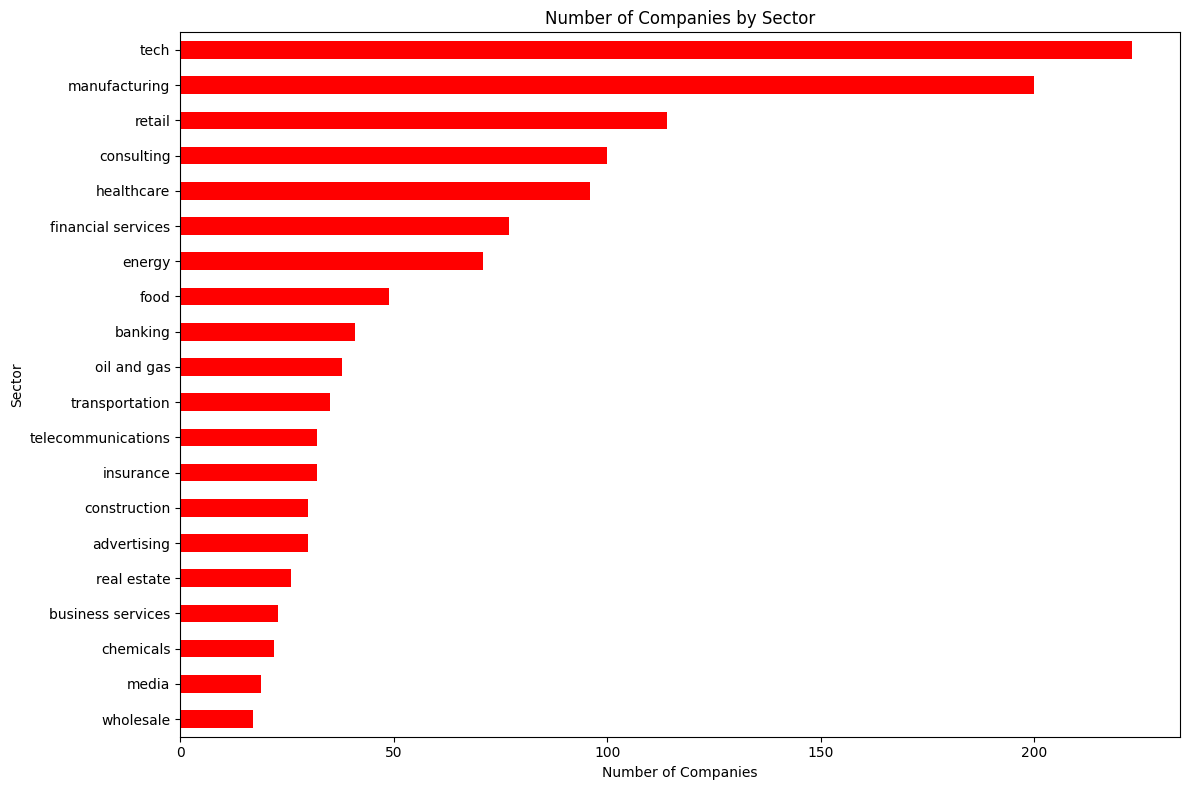

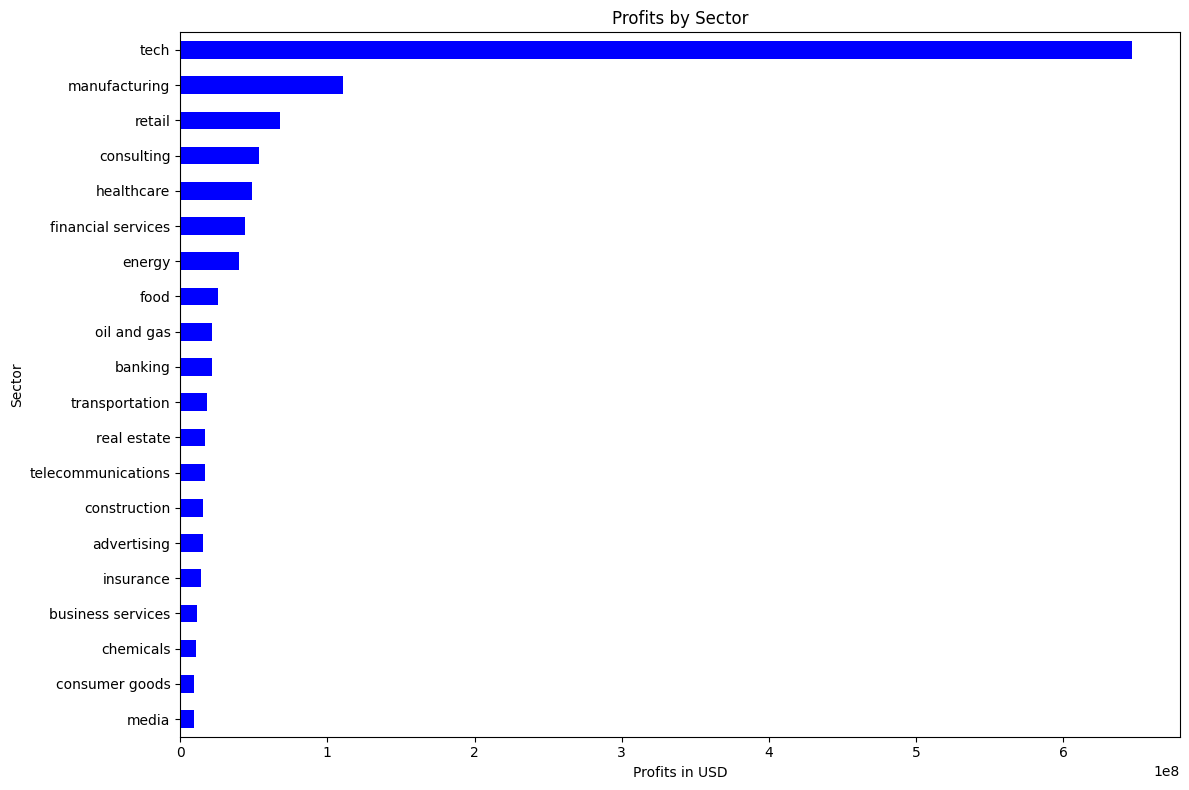

In [92]:
# Define a list of sectors to group into "Others"
#other_sectors = ['media production', 'entertainment', 'legal services', 'events','waste management','mining','automotive', 'aerospace', 'tourism', 'education', 'industrials', 'fitness', 'marketing', 'agriculture']

# Replace specified sectors with "Others"
# aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].apply(lambda x: "others" if x in other_sectors else x)

# Group by 'Sector', summing 'Profits in USD' and counting 'Company Name'
sector_data = aicompany_profits_df.groupby('Sector').agg({
    'Profits in USD': 'sum',
    'Company Name': 'count'
}).rename(columns={'Company Name': 'Number of Companies'})

# Sort by 'Number of Companies' in descending order 
top_sectors_by_companies = sector_data.sort_values('Number of Companies', ascending=True)


# Plotting Number of Companies by Sector (Horizontal Bar Chart)and take the top 20
plt.figure(figsize=(12, 8))
plot = top_sectors_by_companies['Number of Companies'].tail(20).plot(kind='barh', color='red')
plt.title('Number of Companies by Sector')
plt.xlabel('Number of Companies')
plt.tight_layout()
plt.show()
fig = plot.get_figure()
fig.savefig('companies.png', dpi=100)

# Sort by 'Profits in USD' in descending order
sorted_by_profits = sector_data.sort_values('Profits in USD', ascending=True)

# Plotting Profits by Sector (Horizontal Bar Chart) and take the top 20
plt.figure(figsize=(12, 8))
plot = sorted_by_profits['Profits in USD'].tail(20).plot(kind='barh', color='blue')
plt.title('Profits by Sector')
plt.xlabel('Profits in USD')
plt.tight_layout()
plt.show()
fig = plot.get_figure()
fig.savefig('profits.png', dpi=100)



# From this analysis we can see that there is a very large number of manufacturing companies using AI. However, their profitability lags behind technology companies. It would see that as the use of AI in manufacturing becomes more mature, we should expect profitability of the sector to increase overall.